## Packages and Assets

In [1]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


In [2]:
model = keras.models.load_model('../../assets/lstm_assets/lstm_model')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 11, 300)           3110400   
                                                                 
 bidirectional (Bidirectiona  (None, 11, 128)          186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                                 
Total params: 3,400,356
Trainable params: 289,956
Non-tr

In [3]:
# Load the tokenizer from the file
with open('../../assets/lstm_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)
    word_index = tokenizer.word_index

## Functions

In [4]:
def transformDocument(df, column_name, language):
    stop_words = usingStopwords(language)
    df_pp = df.copy()
    # 1. Aplicar preprocessamento nos títulos e textos completos
    if language == 'pt':
        # Substituir símbolos importantes
        df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('-feira', ''))
        df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('+', 'mais '))
        df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('-', 'menos '))
        df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('%', ' por cento'))
        df_pp[column_name] = df_pp[column_name].map(lambda s: removeStopwords(s, stop_words))

    elif language == 'en':
        df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('-', 'less'))
        df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('+', 'plus '))
        df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('%', ' percent'))
        df_pp[column_name] = df_pp[column_name].map(lambda s: removeStopwords(s, stop_words))

    else:
        pass

    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('R$', ''))
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('U$', ''))
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('US$', ''))
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('S&P 500', 'spx'))

    # Transformar em String e Letras Minúsculas nas Mensagens
    df_pp[column_name] = df_pp[column_name].map(lambda s:
                                              normalizarString(s))

    # Remover Pontuações
    # Remover Pontuações
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

    # Remover Emojis
    df_pp[column_name] = df_pp[column_name].map(lambda s: removeEmojis(s))

    # Quebras de Linha desnecessárias
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('\n', ' '))

    # Remover aspas duplas
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('\"', ''))
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('“', ''))
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.replace('”', ''))

    # Remover valores
    df_pp[column_name] = df_pp[column_name].map(lambda s: removeValores(s))

    # Espaços desnecessários
    df_pp[column_name] = df_pp[column_name].map(lambda s: s.strip())
    return df_pp

def removeEmojis(sentence):
    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def removeValores(sentence):
    new_sentece = ''

    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)

    return new_sentece

def usingStopwords(language):
    stop_words = []

    nltk.download('stopwords')

    if language == 'pt':
        stop_words = nltk.corpus.stopwords.words('portuguese')
    elif language == 'en':
        stop_words = nltk.corpus.stopwords.words('english')

    return stop_words

def removeStopwords(text, stop_words):
    tokens = []
    for word in text.split():
        if word not in stop_words:
            tokens.append(word)

    text = ' '.join(tokens)
    return text

def normalizarString(text):
    """
    Função para retirar acentuações e converter para minúscula
    :param text:
    :return text_normalizado
    """
    import unicodedata

    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text.lower())

## Loading test data

In [5]:
test_raw = pd.read_csv('../../assets/data/splits/test/raw.csv')
test_raw

,title,tags,link,label
0,Ação da Vale despenca com relatório da CPI; Ve...,"['Brumadinho', 'Carlos Viana', 'CPI', 'Empresa...",https://www.moneytimes.com.br/acao-da-vale-des...,2
1,Petrobras vê “tendência de estabilização” de c...,"['Brasil', 'Coronavírus', 'Empresas', 'EUA', '...",https://www.moneytimes.com.br/petrobras-ve-ten...,1
2,Itaú define valores e datas de pagamentos de p...,"['Dividendos', 'Economia', 'Empresas', 'Itaú U...",https://www.moneytimes.com.br/itau-define-valo...,3
3,Petrobras (PETR4): mudanças em Conselho e gest...,"['PETR3', 'Petrobras (PETR4)']",https://www.suno.com.br/noticias/mudancas-gera...,1
4,"Dólar em queda com guerra comercial, cheque es...",['dólar'],https://www.sunoresearch.com.br/noticias/dolar...,0
...,...,...,...,...
1797,Francesa Total vende fatia em blocos na Foz do...,"['Amazonas', 'BP', 'Brasil', 'Empresas', 'Ibam...",https://www.moneytimes.com.br/francesa-total-v...,1
1798,Mais uma plataforma começa a produzir no pré-s...,"['Commodities', 'Petrobras', 'Petróleo', 'Pré-...",https://www.moneytimes.com.br/mais-uma-platafo...,1
1799,Ibovespa tem leve alta no começo de mês normal...,"['Ações', 'Banco Central', 'Banco do Brasil', ...",https://www.moneytimes.com.br/ibovespa-fecha-e...,3
1800,Os gringos vêm ou não vêm para a Bolsa?,"['Brasil Plural', 'Colunistas', 'Comprar ou ve...",https://www.moneytimes.com.br/os-gringos-vem-o...,1


In [6]:
test_preprocessed = transformDocument(test_raw, 'title', 'pt')

X_test = test_preprocessed.title
y_test = test_preprocessed.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')
test_padded

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guilherme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([[   29,     5,   763, ...,     0,     0,     0],
       [    3,    79,  1901, ...,     2,    72,   825],
       [    7,   772,   595, ...,     0,     0,     0],
       ...,
       [   10,   139,    11, ...,     0,     0,     0],
       [ 1477, 10091,   684, ...,     0,     0,     0],
       [   55,   219,   174, ...,     0,     0,     0]])

### Functions

In [7]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [8]:
index_word = index2word(word_index)

In [9]:
pred_prob = model.predict(test_padded)

57/57 [==============================] - 3s 9ms/step


In [10]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [11]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[29, 5, 763, 816, 601, 32, 2631, 6198]",acao vale despenca relatorio cpi veja document...,"[acao, vale, despenca, relatorio, cpi, veja, d...",2,2
1,"[3, 79, 1901, 1608, 975, 333, 2, 14, 2, 72, 825]",petrobras ve tendencia estabilizacao casos cov...,"[petrobras, ve, tendencia, estabilizacao, caso...",1,1
2,"[7, 772, 595, 804, 738, 933, 2]",itau define valores datas pagamentos proventos...,"[itau, define, valores, datas, pagamentos, pro...",3,3
3,"[3, 9, 407, 110, 1009, 296, 1175, 1098, 403]",petrobras petr4 mudancas conselho gestao podem...,"[petrobras, petr4, mudancas, conselho, gestao,...",1,1
4,"[28, 12, 166, 126, 1514, 901, 681, 705]",dolar queda guerra comercial cheque especial b...,"[dolar, queda, guerra, comercial, cheque, espe...",0,0
...,...,...,...,...,...
1797,"[3773, 377, 154, 156, 775, 2771, 1487, 3]",francesa total vende fatia blocos foz amazonas...,"[francesa, total, vende, fatia, blocos, foz, a...",1,1
1798,"[702, 326, 727, 1876, 86, 112, 277, 493]",mais plataforma comeca produzir premenos sal b...,"[mais, plataforma, comeca, produzir, premenos,...",0,1
1799,"[10, 139, 11, 3267, 175, 5533, 2078]",ibovespa leve alta comeco mes normalmente volatil,"[ibovespa, leve, alta, comeco, mes, normalment...",0,3
1800,"[1477, 10091, 684, 684, 46]",os gringos vem vem bolsa,"[os, gringos, vem, vem, bolsa]",0,1


### Metrics

In [12]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.70      0.90      0.78       581
           1       0.93      0.76      0.83       628
           2       0.75      0.81      0.78       376
           3       0.87      0.53      0.66       217

    accuracy                           0.79      1802
   macro avg       0.81      0.75      0.76      1802
weighted avg       0.81      0.79      0.79      1802

Confusion Matrix


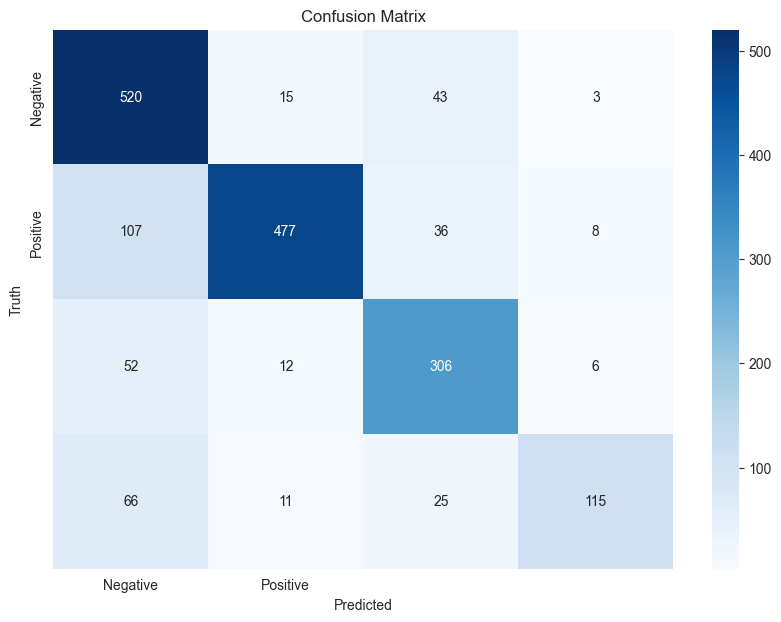

In [13]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)